In [3]:
#we want to define two functions: one to get the IoU, one to get the average time per image compared to cellpose

from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np

import matplotlib.pyplot as plt

In [44]:
#import model
unet = UNet(nbClasses=1)
unet = unet.to('cuda:0')
unet.load_state_dict(torch.load('C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\models\\model3'))

<All keys matched successfully>

In [6]:
#get testing images

cellpose_model_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cellpose_model = getModel(cellpose_model_directory)

images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)
testing_images = images[5:10]
testing_probability_maps, testing_cell_masks = makePredictions(testing_images, cellpose_model)

a
a
a
a
a


In [45]:
#get predictions (calculate time taken per image and average)

predictions = []
times = []
for (k, image) in enumerate(testing_images):
    x = torch.from_numpy(image)
    x = x.unsqueeze(0)
    x = x.unsqueeze(0)
    x = x.to('cuda:0')
    start = time.time()
    prediction = unet(x)[1]
    end = time.time()
    times.append(end-start)
    prediction = torch.sigmoid(prediction)
    prediction = prediction.squeeze(0)
    prediction = prediction.squeeze(0)
    prediction = prediction.cpu().detach().numpy().tolist()
    prediction = cv2.resize(np.array(prediction), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    prediction = np.array(prediction)
    predictions.append(prediction)

In [50]:
print(times)

[0.0020017623901367188, 0.0032074451446533203, 0.0019943714141845703, 0.001993417739868164, 0.001996755599975586]


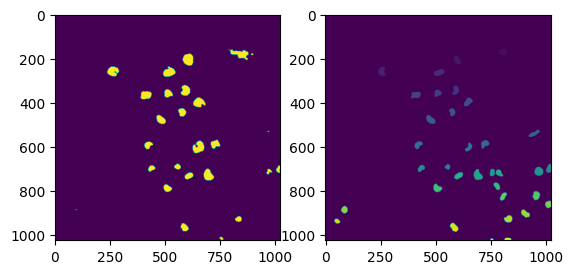

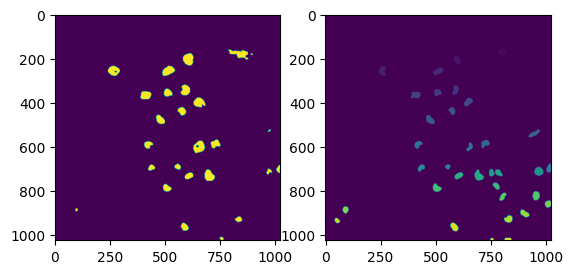

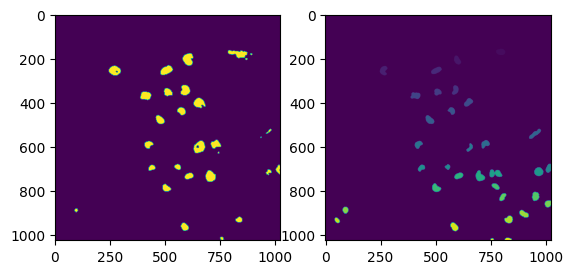

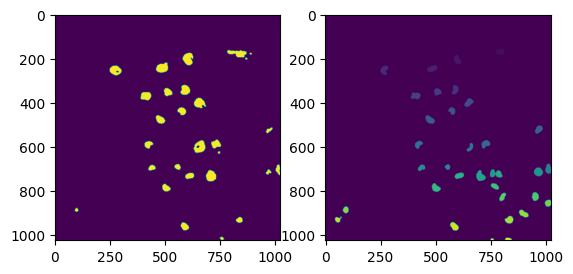

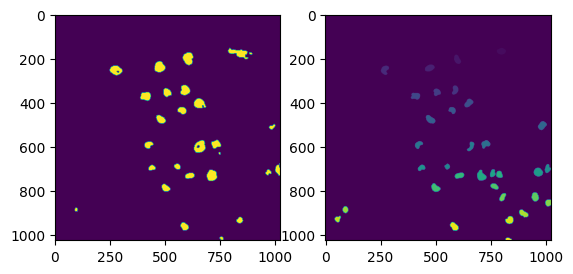

In [49]:
for i in range(len(predictions)):
    y = predictions[i]
    y_binary = np.where(y > 0.07, 1, 0)
    plt.subplot(1,2,1)
    plt.imshow(y_binary)
    plt.subplot(1,2,2)
    plt.imshow(testing_cell_masks[i])
    plt.show()

In [47]:
#get IoU

def getIoU(prediction, cellmask):
    intersection = np.logical_and(prediction, cellmask)
    union = np.logical_or(prediction, cellmask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

for j in range(0,50,1):
    thresh = j/100
    ious = []
    for i in range(len(predictions)):
        y_binary = np.where(predictions[i] > thresh, 1, 0)
        iou = getIoU(y_binary, testing_cell_masks[i])
        ious.append(iou)

    print(thresh, ious)

0.0 [0.026017189025878906, 0.026142120361328125, 0.026363372802734375, 0.02660655975341797, 0.026758193969726562]
0.01 [0.026017189025878906, 0.026142120361328125, 0.026363372802734375, 0.02660655975341797, 0.026758193969726562]
0.02 [0.026024138220502605, 0.026149402261219288, 0.02637454061129705, 0.026618135328015876, 0.026771981115152534]
0.03 [0.324312404287902, 0.3287398901031055, 0.33614599196145495, 0.33548563001152576, 0.33872932985204524]
0.04 [0.37726436113532885, 0.37936613224183396, 0.38799642654105415, 0.3854670501839919, 0.38725081725530414]
0.05 [0.3951335933407067, 0.39516408931394853, 0.4037805653505983, 0.40503060443764344, 0.40888787080517697]
0.06 [0.44456773218754425, 0.44017900846094676, 0.453683938917689, 0.454983515090033, 0.45493286899143104]
0.07 [0.4805642208056422, 0.47689671788831184, 0.4830070983007098, 0.490798845552996, 0.4908413373222065]
0.08 [0.48656396594660334, 0.47884390424833806, 0.4821684126166352, 0.493320124540051, 0.4924076875665378]
0.09 [0.4